In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix , auc

from sklearn.pipeline import Pipeline,make_pipeline

In [65]:
def model_basic(x_train, y_train, x_test, y_test): 
    models = [
        LogisticRegression(),
        LinearDiscriminantAnalysis(),
        GaussianNB(),
        RandomForestClassifier(),
        XGBClassifier()
    ]

    rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


    for clf in models:
        clf = clf.fit(x_train, y_train)
    #1열:Train
        y_hat = clf.predict(x_train)
        results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
    #2열:Test
        y_hat = clf.predict(x_test)
        results = (round(accuracy_score(y_test,y_hat),2),
                        round(precision_score(y_test,y_hat),2),
                        round(recall_score(y_test,y_hat),2),
                        round(f1_score(y_test,y_hat),2),
                        round(roc_auc_score(y_test,y_hat),2))

        rdict['model'].append(clf); 
        rdict['acc_train'].append(results_train[0])
        rdict['auc_train'].append(results_train[1])
        
        rdict['acc_test'].append(results[0])
        rdict['precision'].append(results[1])
        rdict['recall'].append(results[2])
        rdict['f1_score'].append(results[3])
        rdict['AUC_test'].append(results[4])   

        confusion = confusion_matrix(y_test, y_hat)

        print(confusion)

    rdf_final = pd.DataFrame(data=rdict)
    return rdf_final

In [66]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [67]:
def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc

In [68]:
['EBIT/총자산', '현금흐름 대 자산', '현금흐름 대 매출액', 'abs(영업현금흐름-당기순이익)/매출액',
       '누적수익성비율', '총자본회전률', '금융비용부담률', '당기전기영업손익', 'TMD', '매출액총이익률',
       '자기자본순이익률', 'ROA변화율']

['EBIT/총자산',
 '현금흐름 대 자산',
 '현금흐름 대 매출액',
 'abs(영업현금흐름-당기순이익)/매출액',
 '누적수익성비율',
 '총자본회전률',
 '금융비용부담률',
 '당기전기영업손익',
 'TMD',
 '매출액총이익률',
 '자기자본순이익률',
 'ROA변화율']

In [101]:
## 불균형 처리 안한 데이터 
train = pd.read_csv("./datasets/통계검증완료/코스닥_standard_train.csv", index_col=0)
test = pd.read_csv("./datasets/통계검증완료/코스닥_standard_test.csv", index_col=0)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']

최종_col_3=['EBIT/총자산', 'abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', '총자본회전률', '금융비용부담률',
   '당기전기영업손익', 'TMD']


train_x = train[최종_col_3]
train_y = train["target_3"]

test_x = test[최종_col_3]
test_y = test["target_3"]

In [102]:
# # 불균형 처리한 후 데이터
# train = pd.read_csv('./datasets/불균형처리/boder_코스닥_standar_train.csv',index_col=0)
# train_x = train.drop(['target_3'],axis=1)
# train_y = train['target_3']

# test = pd.read_csv('./datasets/불균형처리/코스닥_standard_test.csv',index_col=0)
# test_x = test.drop(['회사명','거래소코드','회계년도','산업군','target_3'],axis=1)
# test_y = test['target_3']

## random과grid차이
- random은 넓은 범위에 하이퍼파라미터를 찾을때 효율적 랜덤한 조합으로 학습시키기때문 - 그러나 어떤조합은 적합시키지 않을수있음 그러므로 반복횟수를 적절하게 조절하는것이필요
- grid는 모든경우에 수를 적합시킴 그러므로 조합의 수가 많아진다면 시간이 오래걸리기때문에 오히려 random으로했을때 시간적으로 효율적일 수 있음
------------------------------------

## LOGISTIC

In [103]:
lr=LogisticRegression(random_state=1,n_jobs=-1,fit_intercept=True)
param = {
    'solver' :['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C': [0.001 ,0.01,0.02,0.03,0.04,0.05, 0.1,0.5, 1],
    'penalty': ['l2'],
    'max_iter':[100,300,500],
    'class_weight':[None,'balanced']
}

grid_lr = GridSearchCV(lr,n_jobs=-1,scoring='f1',cv=5,param_grid=param,refit=True)
grid_lr.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

    param_C param_class_weight param_max_iter param_penalty     param_solver  \
0     0.001               None            100            l2            lbfgs   
1     0.001               None            100            l2        liblinear   
2     0.001               None            100            l2        newton-cg   
3     0.001               None            100            l2  newton-cholesky   
4     0.001               None            100            l2              sag   
..      ...                ...            ...           ...              ...   
319       1           balanced            500            l2        liblinear   
320       1           balanced            500            l2        newton-cg   
321       1           balanced            500            l2  newton-cholesky   
322       1           balanced            500            l2              sag   
323       1           balanced            500            l2             saga   

                                       

In [104]:
print(grid_lr.best_params_)
pred = grid_lr.predict(test_x)
pred_prob = grid_lr.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
##############
 [[2793   21]
 [  27   45]] ############
 acc_score: 0.9833679833679834
 f1_score: 0.6521739130434783 
 precision: 0.6818181818181818 
 recall: 0.625


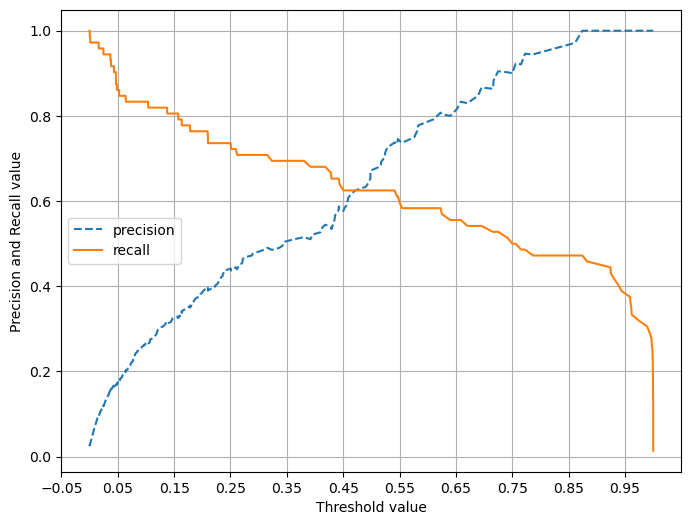

In [105]:
precision_recall_curve_plot(test_y,pred_prob)

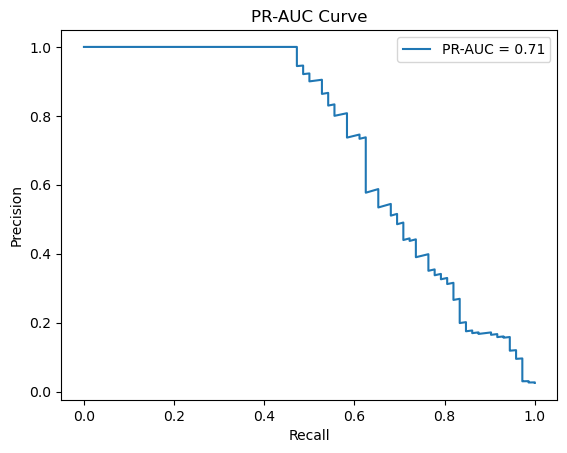

0.7131451132913803

In [106]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

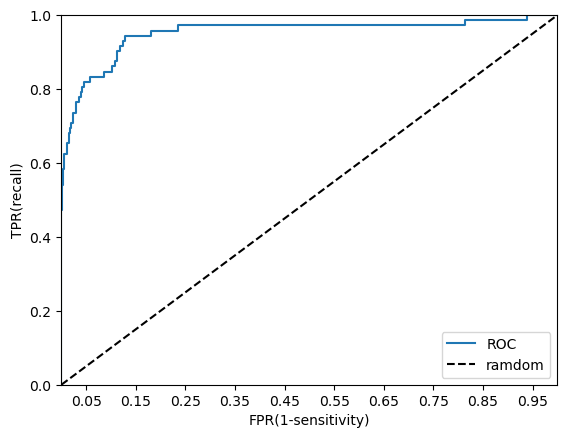

auc 값: 0.9513


In [107]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## LDA

In [110]:
proi = train_y.value_counts(property)

In [111]:
lda = LinearDiscriminantAnalysis()
param = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None,'auto'],
    'priors': [[proi[0],proi[1]],None]
}

grid_lda = GridSearchCV(lda, param_grid=param, scoring='accuracy', cv=5, n_jobs=-1, refit=True)
grid_lda.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_lda.cv_results_)
print(scores_df.loc[:, 'param_solver':'mean_test_score'])


   param_solver                                             params  \
0           svd  {'priors': [0.9669206094627105, 0.033079390537...   
1          lsqr  {'priors': [0.9669206094627105, 0.033079390537...   
2         eigen  {'priors': [0.9669206094627105, 0.033079390537...   
3           svd  {'priors': [0.9669206094627105, 0.033079390537...   
4          lsqr  {'priors': [0.9669206094627105, 0.033079390537...   
5         eigen  {'priors': [0.9669206094627105, 0.033079390537...   
6           svd  {'priors': None, 'shrinkage': None, 'solver': ...   
7          lsqr  {'priors': None, 'shrinkage': None, 'solver': ...   
8         eigen  {'priors': None, 'shrinkage': None, 'solver': ...   
9           svd  {'priors': None, 'shrinkage': 'auto', 'solver'...   
10         lsqr  {'priors': None, 'shrinkage': 'auto', 'solver'...   
11        eigen  {'priors': None, 'shrinkage': 'auto', 'solver'...   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.972946     

c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\msi\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py", line 615, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotImplementedError: shrinkage not supported with 'svd' solver.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\msi

In [112]:
print(grid_lda.best_params_)
pred = grid_lda.predict(test_x)
pred_prob = grid_lda.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'priors': [0.9669206094627105, 0.0330793905372895], 'shrinkage': None, 'solver': 'svd'}
##############
 [[2773   41]
 [  27   45]] ############
 acc_score: 0.9764379764379765
 f1_score: 0.569620253164557 
 precision: 0.5232558139534884 
 recall: 0.625


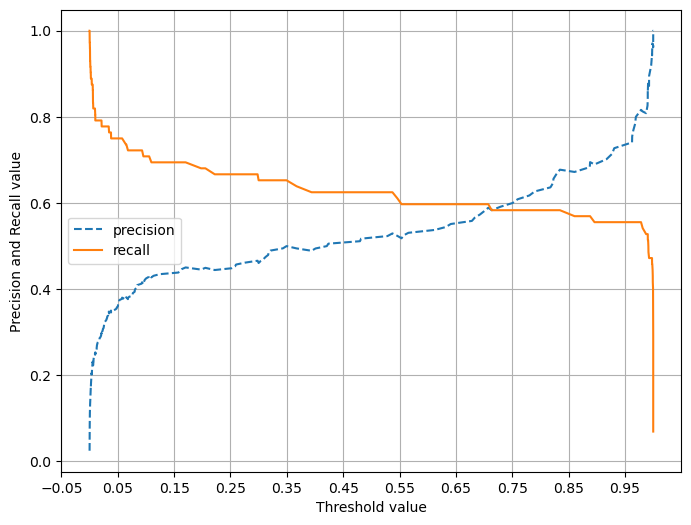

In [113]:
precision_recall_curve_plot(test_y,pred_prob)

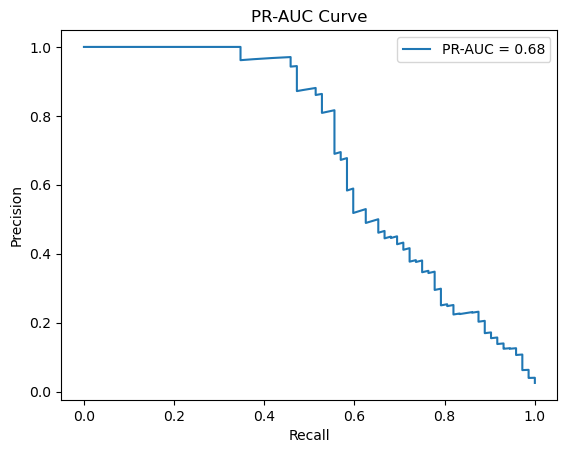

0.6843061497449315

In [114]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

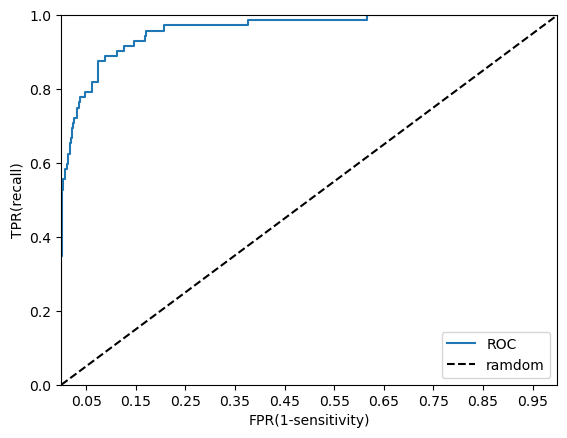

auc 값: 0.9608


In [115]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## Gaussian_NB

In [116]:
a = train_y.value_counts(property)

In [117]:
nb=GaussianNB(priors=[a[0],a[1]])

nb.fit(train_x,train_y)

pred = nb.predict(test_x)
pred_prob = nb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

##############
 [[2662  152]
 [  13   59]] ############
 acc_score: 0.9428274428274428
 f1_score: 0.41696113074204955 
 precision: 0.2796208530805687 
 recall: 0.8194444444444444


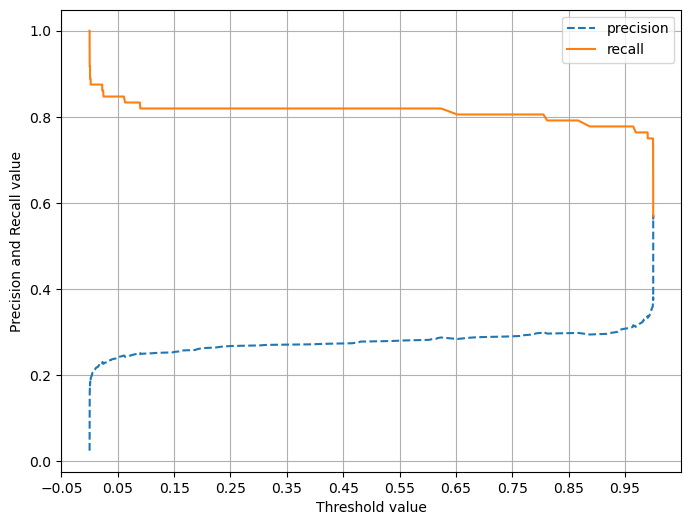

In [118]:
precision_recall_curve_plot(test_y,pred_prob)

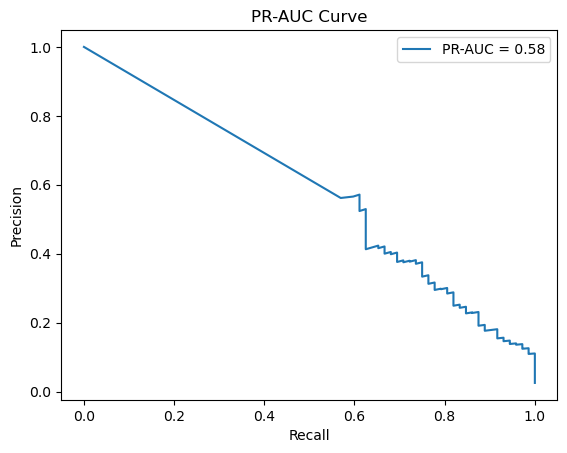

0.5784305906162318

In [119]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

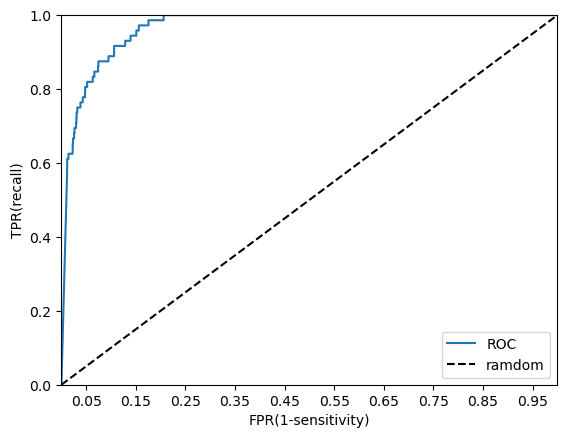

auc 값: 0.9681


In [120]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

## RandomForest

In [30]:
rf=RandomForestClassifier(random_state=1,n_jobs=-1,)
param = {
    'class_weight' :['balanced_subsample','balanced'],
    'n_estimators': [50, 100, 200],
    'max_depth': [3,5,7,10 ],
    'min_samples_split': [2, 5,7, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_rf = GridSearchCV(rf,n_jobs=-1,scoring='accuracy',cv=5,param_grid=param,refit=True)
grid_rf.fit(train_x,train_y)

scores_df = pd.DataFrame(grid_rf.cv_results_)
print(scores_df.iloc[:,4:])

c:\Users\msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


     param_class_weight param_max_depth param_max_features  \
0    balanced_subsample               3               auto   
1    balanced_subsample               3               auto   
2    balanced_subsample               3               auto   
3    balanced_subsample               3               auto   
4    balanced_subsample               3               auto   
..                  ...             ...                ...   
859            balanced              10               log2   
860            balanced              10               log2   
861            balanced              10               log2   
862            balanced              10               log2   
863            balanced              10               log2   

    param_min_samples_leaf param_min_samples_split param_n_estimators  \
0                        1                       2                 50   
1                        1                       2                100   
2                        1          

In [40]:
print(grid_rf.best_params_)
pred = grid_rf.predict(test_x)
pred_prob = grid_rf.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
##############
 [[3307  237]
 [  19   53]] ############
 acc_score: 0.9292035398230089
 f1_score: 0.292817679558011 
 precision: 0.18275862068965518 
 recall: 0.7361111111111112


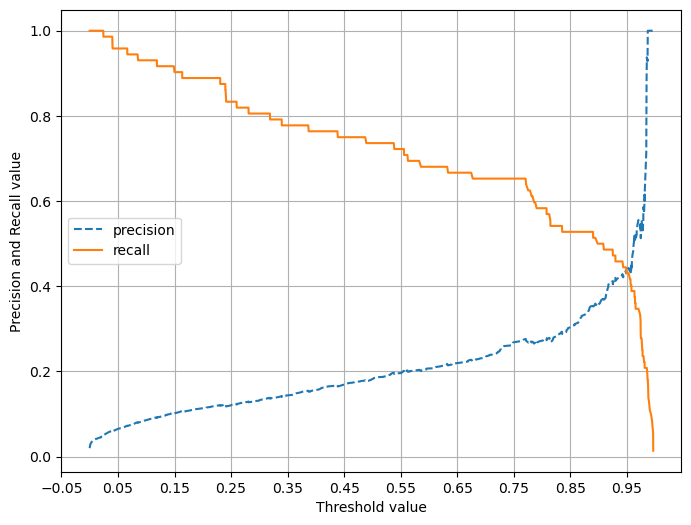

In [32]:
precision_recall_curve_plot(test_y,pred_prob)

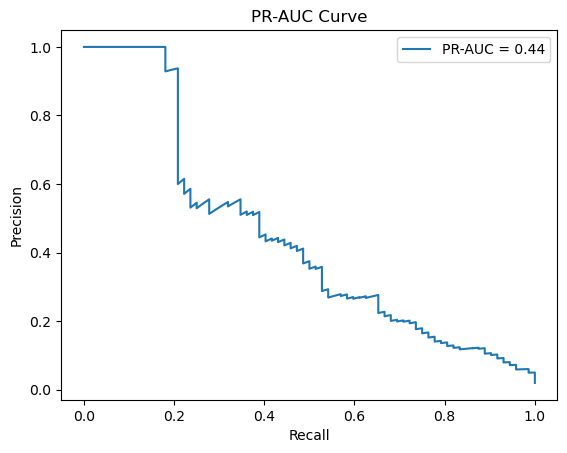

0.44208663360329287

In [33]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

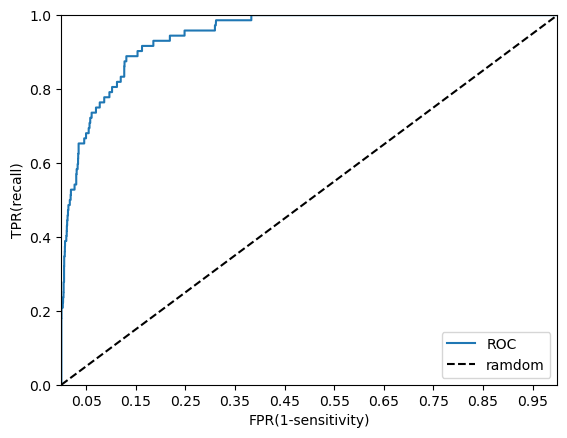

auc 값: 0.9449


In [34]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')

### xgboost

In [35]:
xgb = XGBClassifier(random_state=1, n_jobs=-1)
param = {
    'class_weight': ['balanced_subsample', 'balanced'],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.2],
}

grid_xgb = GridSearchCV(xgb, n_jobs=-1, scoring='f1', cv=5, param_grid=param, refit=True)
grid_xgb.fit(train_x, train_y)

scores_df = pd.DataFrame(grid_xgb.cv_results_)
print(scores_df.iloc[:, 4:])


[13:21:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

      param_class_weight param_colsample_bytree param_gamma  \
0     balanced_subsample                    0.7           0   
1     balanced_subsample                    0.7           0   
2     balanced_subsample                    0.7           0   
3     balanced_subsample                    0.7           0   
4     balanced_subsample                    0.7           0   
...                  ...                    ...         ...   
4369            balanced                    0.9         0.2   
4370            balanced                    0.9         0.2   
4371            balanced                    0.9         0.2   
4372            balanced                    0.9         0.2   
4373            balanced                    0.9         0.2   

     param_learning_rate param_max_depth 

In [41]:
print(grid_xgb.best_params_)
pred = grid_xgb.predict(test_x)
pred_prob = grid_xgb.predict_proba(test_x)[:,1].reshape(-1,1)
eval(pred=pred,test=test_y)

{'class_weight': 'balanced_subsample', 'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
##############
 [[3384  160]
 [  22   50]] ############
 acc_score: 0.9496681415929203
 f1_score: 0.35460992907801414 
 precision: 0.23809523809523808 
 recall: 0.6944444444444444


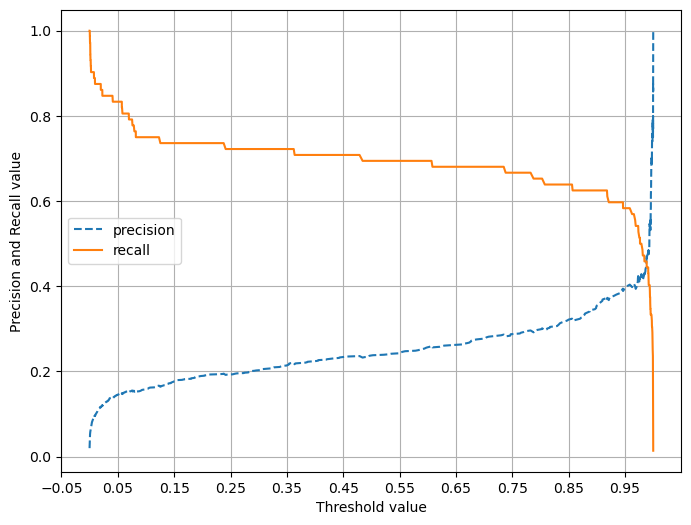

In [42]:
precision_recall_curve_plot(test_y,pred_prob)

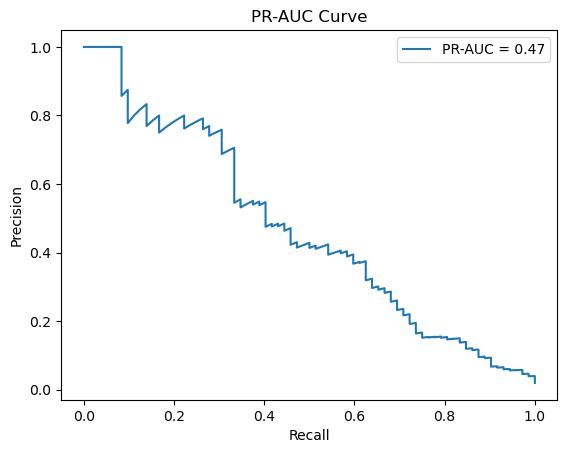

0.46640792644287865

In [43]:
plot_pr_auc_curve(test_y,pred_prob)
get_pr_auc_score(test_y,pred_prob)

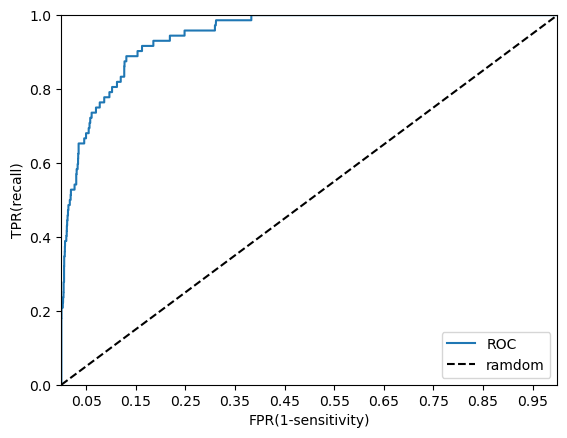

auc 값: 0.9449


In [39]:
## roc 커브 auc 값
roc_curve_plot(test_y,pred_prob)
auc_score = roc_auc_score(test_y,pred_prob)
print(f'auc 값: {np.round(auc_score,4)}')